In [2]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from torchvision import models
# from torchsummary import summary as model_summary

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 5, kernel_size=1)
        
    def forward(self, x):
        x = self.block1(x)
        x1 = x
        x = self.block2(x)
        x2 = x
        x = self.block3(x)
        x3 = x
        x = self.block4(x)
        x4 = x
        x = self.block5(x)
        x5 = x
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

model = FCN()
# model_summary(model, (1,512,512), device='cpu')

In [2]:
model = model.to('cuda')

In [3]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.transforms as trnasforms
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import math
warnings.filterwarnings('ignore') ## ignore warnings
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
# meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
timg = tt.imread('512dataset/apparel/'+os.listdir('512dataset/apparel')[10000], meta = meta, gray = True)
# field = timg.clone()

# tt.show(timg)

In [15]:
# target = timg.unsqueeze(0)
target = target.unsqueeze(0)

In [4]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [5]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [6]:
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        # self.sim_dir = sim_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.jpeg'))
        # self.sim_list = sorted(glob.glob(sim_dir+'*.png'))
    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        target = target.unsqueeze(0)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target

In [7]:
batch_size = 16
target_dir = '512dataset/dishes/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
target_dataset = Dataset512(target_dir = target_dir, meta = meta)
size = len(target_dataset)
# dataloader = DataLoader(binary_dataset, batch_size = batch_size, shuffle = True)
train_size = int(size * 0.8)
valid_size = size - train_size

train_dataset, valid_dataset = random_split(target_dataset, [train_size, valid_size])
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(valid_dataset, shuffle = True)

In [9]:
import torch
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
writer = SummaryWriter()
# model = test()
model = FCN()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sign_function = SignFunction.apply
epochs = 1000
z = 5e-3
path = 'models/'
criterion = nn.MSELoss()
valid_image = valid_dataset[0].unsqueeze(0)
for epoch in range(epochs):
    for batch_idx, target in enumerate(trainloader):
        pred = model(target)
        pred = sign_function(pred)
        sim = tt.simulate(pred,z)
        sim = torch.sum(sim, dim=1)/5
        loss = criterion(target, sim.abs()**2)
        # loss = criterion(target, pred)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        print(f'Epoch {epoch:4d}/{epochs} Batch {batch_idx + 1}/{len(trainloader)} Cost: {loss.item():.6f}')
    pred = model(valid_image)
    pred = sign_function(pred)
    sim = tt.simulate(pred,z)
    sim = torch.sum(sim, dim=1)/5
    sim = sim.abs()**2
    valid_loss = criterion(valid_image, sim)
    psnr = get_psnr(valid_image, sim)
    writer.add_scalar("PSNR/train", psnr, epoch)
    print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f} PSNR : {psnr}')
    torch.save(model, path + 'fcn2.pt')
writer.close()

Epoch    0/1000 Batch 1/60 Cost: 0.215528
Epoch    0/1000 Batch 2/60 Cost: 0.209113
Epoch    0/1000 Batch 3/60 Cost: 0.176315
Epoch    0/1000 Batch 4/60 Cost: 0.187659
Epoch    0/1000 Batch 5/60 Cost: 0.173955
Epoch    0/1000 Batch 6/60 Cost: 0.178846
Epoch    0/1000 Batch 7/60 Cost: 0.176803
Epoch    0/1000 Batch 8/60 Cost: 0.178648
Epoch    0/1000 Batch 9/60 Cost: 0.146936
Epoch    0/1000 Batch 10/60 Cost: 0.142838
Epoch    0/1000 Batch 11/60 Cost: 0.123082
Epoch    0/1000 Batch 12/60 Cost: 0.143248
Epoch    0/1000 Batch 13/60 Cost: 0.151577
Epoch    0/1000 Batch 14/60 Cost: 0.128132
Epoch    0/1000 Batch 15/60 Cost: 0.134631
Epoch    0/1000 Batch 16/60 Cost: 0.147973
Epoch    0/1000 Batch 17/60 Cost: 0.134496
Epoch    0/1000 Batch 18/60 Cost: 0.127868
Epoch    0/1000 Batch 19/60 Cost: 0.144188
Epoch    0/1000 Batch 20/60 Cost: 0.143899
Epoch    0/1000 Batch 21/60 Cost: 0.122863
Epoch    0/1000 Batch 22/60 Cost: 0.122309
Epoch    0/1000 Batch 23/60 Cost: 0.141205
Epoch    0/1000 Batc

KeyboardInterrupt: 

In [10]:
valid_image.shape

torch.Size([1, 1, 512, 512])

In [20]:
pred = model(valid_image)
binary = sign_function(pred)
sim = tt.simulate(binary, z)
sim = torch.sum(sim, dim=1)/5
sim = sim.abs()

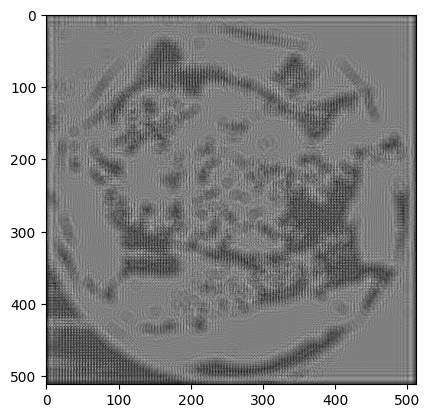

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [23]:
tt.simulate(binary,z)[0][0]

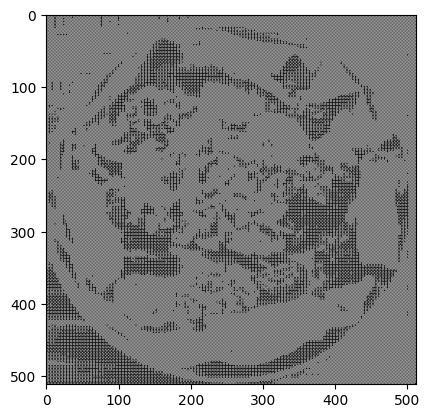

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [14]:
binary[0][0]

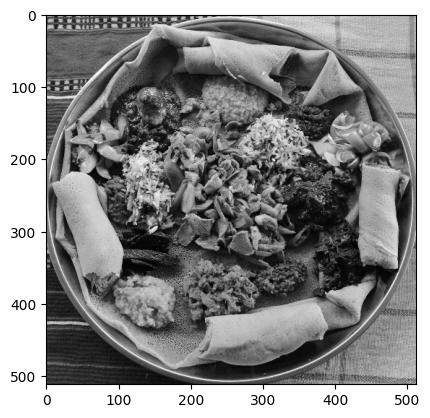

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [15]:
valid_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


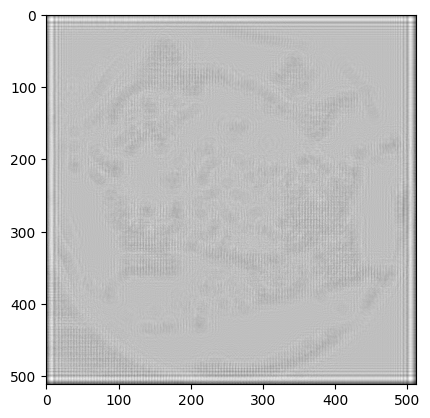

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [21]:
sim